In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import kds

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [2]:
import os

%cd data

c:\Users\Julian\Documents\projs\home-credit-default-risk\data


In [3]:
def show_cat_col_values(df):
    cats = df.select_dtypes(include = ['object'])

    for col in cats:
        ratios = []
        values = pd.DataFrame(df[col].value_counts())
        for value in values[col].values:
            total = np.sum(values[col].values)
            ratios.append(value/total)

        values['Ratio'] = ratios

        print(values.sort_values(by = 'Ratio', ascending = False))
        print("\n")

def show_missing_values(df):
    na_dict = {}
    for col in df.columns:
        na = df[col].isna().sum()
        total = len(df[col])

        na_dict[col] = f"{round(100*na/total,2)}%"

    print(pd.Series(na_dict).sort_values(ascending = False))

def remove_cat_col_values(df, threshold):
    """
    If one single value dominates the entire column, then we remove the column entirely, as there is too little variation in the column values
    """
    assert 0 <= threshold <= 1, "threshold must be between 0 and 1"
    cats = df.select_dtypes(include = ['object'])
    for col in cats:
        print(col)
        values = pd.DataFrame(df[col].value_counts())
        for value in values[col].values:
            total = np.sum(values[col].values)
            if value/total >= threshold:
                df = df.drop([col], axis = 1)
    return df


def remove_missing_values(df, threshold):
    assert 0 <= threshold <= 1, "threshold must be between 0 and 1"

    for col in df.columns:
        na = df[col].isna().sum()
        total = len(df[col])

        if na/total > threshold:
            df = df.drop([col], axis = 1)

    return df

def remove_bad_rows(df, col, value):
    rows = df.loc[df[col] == value]
    
    df = df.drop(rows.index, axis = 0)
    
    return df

def show_ratio(df, target, col):
    dict_ = {}
    for value in set(df[col].values):
        
        target_1 = df.loc[(df[target] == 1) & (df[col] == value)]
        target_0 = df.loc[(df[target] == 0) & (df[col] == value)]

        if len(target_1) == len(target_0) == 0:
            dict_[value] = -1
        elif len(target_0) == 0:
            dict_[value] = -2
        else:
            dict_[value] = len(target_1)/len(target_0)
    
    series = pd.Series(dict_).sort_values(ascending = False)
    series = series.replace({-1: "no values found", -2: f"{value} has all target values of 1"})
    print(col)
    print(series)
    print("\n")

def show_ratio_by_target(df, target, cols = None):
    """
    This can take either a list, string, or all of the object dataframes in the dataframe
    """
    if isinstance(cols, str):
        show_ratio(df, target, cols)

    elif isinstance(cols, list):
        for col in cols:
            if col != target:
                show_ratio(df, target, col)

    elif isinstance(df, pd.DataFrame):
        for col in df.select_dtypes('object'):
            if col != target:
                show_ratio(df, target, col)

    else:
        return "Invalid type for parameter col"


def show_unique_keys(df):
    for col in df.columns:
        print(col, df[col].is_unique)

def get_cat_agg(df, col, type):
    cat_agg = {}
    for i in range(len(df.columns)):
        if col in df.columns[i]:
            cat_agg[df.columns[i]] = type
    
    return cat_agg


In [4]:
def show_evaluation(x, y, model, train = False):
    # retrieve just the probabilities for the positive class
    yprob = model.predict_proba(x)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred = model.predict(x)

    auc_pr = metrics.average_precision_score(y,yprob)
    acc_score = metrics.accuracy_score(y,ypred)
    conf_mat = metrics.confusion_matrix(y,ypred)
    rep = metrics.classification_report(y,ypred)
    auc = roc_auc_score(y,yprob)

    if train:
        print('-----------------Train Set Evaluation -----------------')
    else:
        print('-----------------Test Set Evaluation -----------------')

    print('Accuracy Score:  %0.4f \n' % acc_score)
    print('Area under ROC Curve:  %0.4f \n' % auc)
    print('Average Precision Score:  %0.4f \n' % auc_pr)
    print('Confusion Matrix:')
    print(pd.DataFrame(conf_mat, columns = ['Positive Prediction', 'Negative Prediction'], index = ['Positive Class', 'Negative Class']))
    print("\n")
    print('Classification Report:')
    print(rep)


def show_plot_metrics(x_train, x_test, y_train, y_test, model):
    show_auc_roc_plot(x_train, x_test, y_train, y_test, model)
    show_pr_roc_plot(x_train, x_test, y_train, y_test, model)
    show_lift_chart(x_train, x_test, y_train, y_test, model)
    show_gains_chart(x_train, x_test, y_train, y_test, model)

def show_auc_roc_plot(x_train, x_test, y_train, y_test, model):
    plt.figure(figsize=(14,6))

    yprob_test = model.predict_proba(x_test)[:,1]

    ypred_test = model.predict(x_test)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, yprob_test)
    auc_roc_test = metrics.roc_auc_score(y_test, yprob_test)

    plt.subplot(1,2,1)
    plt.plot(fpr_test,tpr_test, color='orange',label='XGBoost (area = %0.2f)' % auc_roc_test)
    plt.plot([0,1],[0,1],linestyle='--',color = 'blue',label='Random Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC ROC Curve (Test Set)')

    yprob_train = model.predict_proba(x_train)[:,1]

    ypred_train = model.predict(x_train)

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, yprob_train)
    auc_roc_train = metrics.roc_auc_score(y_train, yprob_train)

    plt.subplot(1,2,2)
    plt.plot(fpr_train,tpr_train, color='orange',label='XGBoost (area = %0.2f)' % auc_roc_train)
    plt.plot([0,1],[0,1],linestyle='--',color = 'blue',label='Random Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC ROC Curve (Train Set)')

    

def show_pr_roc_plot(x_train, x_test, y_train, y_test, model):
    plt.figure(figsize=(14,6))
    
    yprob_test = model.predict_proba(x_test)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred_test = model.predict(x_test)

    precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_test, yprob_test)
    auc_pr_test = metrics.average_precision_score(y_test,yprob_test)
    no_skill = sum(y_test)/len(y_test)
    plt.subplot(1,2,1)
    plt.plot(recall_test,precision_test, color='green',label='XGBoost (area = %0.2f)' % auc_pr_test)
    plt.plot([0, 1], [no_skill, no_skill],linestyle='--',color = 'blue',label='Random (%0.3f)' % no_skill)
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve (Test Set)')

    yprob_train = model.predict_proba(x_train)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred_train = model.predict(x_train)

    precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_train, yprob_train)
    auc_pr_train = metrics.average_precision_score(y_train,yprob_train)
    no_skill = sum(y_train)/len(y_train)
    plt.subplot(1,2,2)
    plt.plot(recall_train,precision_train, color='green',label='XGBoost (area = %0.2f)' % auc_pr_train)
    plt.plot([0, 1], [no_skill, no_skill],linestyle='--',color = 'blue',label='Random (%0.3f)' % no_skill)
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve (Train Set)')

def show_gains_chart(x_train, x_test, y_train, y_test, model):
    plt.figure(figsize=(14,6))
    #Cumulative Gain Plot Test Set
    yprob_test = model.predict_proba(x_test)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred_test = model.predict(x_test)
    fig, ax = plt.subplots()
    kds.metrics.plot_cumulative_gain(y_test,yprob_test)

    ax.legend().get_texts()[0].set_text('XGBoost')
    plt.ylabel('Gain')
    plt.title('Cumulative Gain Plot (Test Set)')
    #plt.savefig('Gains_Plot_Test.png')

    #Cumulative Gain Plot Training Set
    yprob_train = model.predict_proba(x_train)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred_train = model.predict(x_train)
    fig, ax = plt.subplots()
    kds.metrics.plot_cumulative_gain(y_train,yprob_train)
    ax.legend().get_texts()[0].set_text('XGBoost')
    plt.ylabel('Gain')
    plt.title('Cumulative Gain Plot (Training Set)')
    #plt.savefig('Gains_Plot_Train.png')

def show_lift_chart(x_train, x_test, y_train, y_test, model):

    plt.figure(figsize=(14,6))
    #Lift Plot Test Set
    yprob_test = model.predict_proba(x_test)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred_test = model.predict(x_test)
    fig, ax = plt.subplots()
    kds.metrics.plot_lift(y_test,yprob_test)
    ax.legend().get_texts()[0].set_text('XGBoost')
    plt.title('Lift Plot (Test Set)')
    #plt.savefig('Lift_Plot_Test.png')

    #Lift Plot Training Set
    yprob_train = model.predict_proba(x_train)[:,1]

    #retrieve the predicted class for each of the test set observations
    ypred_train = model.predict(x_train)
    fig, ax = plt.subplots()
    kds.metrics.plot_lift(y_train,yprob_train)
    ax.legend().get_texts()[0].set_text('XGBoost')
    plt.title('Lift Plot (Training Set)')
    #plt.savefig('Lift_Plot_Train.png')

In [5]:
raw_data = pd.read_csv(os.getcwd()+"\\data.csv")


In [6]:
raw_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_DAYS_CREDIT_mean,bureau_CREDIT_DAY_OVERDUE_mean,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_max,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_CNT_CREDIT_PROLONG_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_var,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Mortgage_sum,credit_card_MONTHS_BALANCE_max,credit_card_MONTHS_BALANCE_mean,credit_card_MONTHS_BALANCE_std,credit_card_AMT_BALANCE_max,credit_card_AMT_BALANCE_sum,credit_card_AMT_CREDIT_LIMIT_ACTUAL_max,credit_card_AMT_CREDIT_LIMIT_ACTUAL_sum,credit_card_AMT_CREDIT_LIMIT_ACTUAL_std,credit_card_AMT_DRAWINGS_ATM_CURRENT_max,credit_card_AMT_DRAWINGS_ATM_CURRENT_mean,credit_card_AMT_DRAWINGS_ATM_CURRENT_sum,credit_card_AMT_DRAWINGS_ATM_CURRENT_median,credit_card_AMT_DRAWINGS_CURRENT_max,credit_card_AMT_DRAWINGS_CURRENT_mean,credit_card_AMT_DRAWINGS_CURRENT_sum,credit_card_AMT_DRAWINGS_CURRENT_median,credit_card_AMT_DRAWINGS_OTHER_CURRENT_max,credit_card_AMT_DRAWINGS_OTHER_CURRENT_mean,credit_card_AMT_DRAWINGS_OTHER_CURRENT_median,credit_card_AMT_DRAWINGS_POS_CURRENT_max,credit_card_AMT_DRAWINGS_POS_CURRENT_mean,credit_card_AMT_DRAWINGS_POS_CURRENT_sum,credit_card_AMT_PAYMENT_CURRENT_max,credit_card_AMT_PAYMENT_CURRENT_median,credit_card_CNT_DRAWINGS_ATM_CURRENT_max,credit_card_CNT_DRAWINGS_ATM_CURRENT_mean,credit_card_CNT_DRAWINGS_ATM_CURRENT_sum,credit_card_CNT_DRAWINGS_ATM_CURRENT_median,credit_card_CNT_DRAWINGS_CURRENT_max,credit_card_CNT_DRAWINGS_CURRENT_mean,credit_card_CNT_DRAWINGS_CURRENT_sum,credit_card_CNT_DRAWINGS_OTHER_CURRENT_max,credit_card_CNT_DRAWINGS_OTHER_CURRENT_mean,credit_card_CNT_DRAWINGS_OTHER_CURRENT_sum,credit_card_CNT_INSTALMENT_MATURE_CUM_max,credit_card_SK_DPD_max,credit_card_SK_DPD_DEF_max,credit_card_PNT_BALANCE_DRAWINGS_ATM_max,credit_card_PNT_BALANCE_DRAWINGS_ATM_mean,credit_card_PNT_BALANCE_DRAWINGS_ATM_median,credit_card_PNT_BALANCE_DRAWINGS_ATM_std,credit_card_AVG_DRAWINGS_ATM_CURRENT_max,credit_card_AVG_DRAWINGS_ATM_CURRENT_mean,credit_card_AVG_DRAWINGS_POS_CURRENT_max,credit_card_AVG_DRAWINGS_POS_CURRENT_mean,credit_card_AVG_DRAWINGS_POS_CURRENT_sum,cash_balance_CNT_INSTALMENT_min,cash_balance_CNT_INSTALMENT_mean,cash_balance_CNT_INSTALMENT_max,cash_balance_CNT_INSTALMENT_FUTURE_min,cash_balance_SK_DPD_min,cash_balance_SK_DPD_mean,cash_balance_SK_DPD_DEF_mean,prev_app_AMT_ANNUITY_max,prev_app_AMT_ANNUITY_mean,prev_app_AMT_ANNUITY_min,prev_app_AMT_APPLICATION_max,prev_app_AMT_APPLICATION_mean,prev_app_AMT_APPLICATION_min,prev_app_AMT_DOWN_PAYMENT_max,prev_app_AMT_DOWN_PAYMENT_min,prev_app_AMT_GOODS_PRICE_min,prev_app_RATE_DOWN_PAYMENT_max,prev_app_RATE_DOWN_PAYMENT_mean,prev_app_RATE_DOWN_PAYMENT_min,prev_app_DAYS_DECISION_max,prev_app_DAYS_DECISION_mean,prev_app_DAYS_DECISION_min,prev_app_DAYS_DECISION_std,prev_app_CNT_PAYMENT_max,prev_app_CNT_PAYMENT_mean,prev_app_CNT_PAYMENT_min,prev_app_DAYS_FIRST_DUE_max,prev_app_DAYS_LA

In [7]:
print(raw_data.shape)

(307505, 336)


In [8]:
raw_data.dtypes

SK_ID_CURR                                                            int64
TARGET                                                                int64
CNT_CHILDREN                                                          int64
AMT_INCOME_TOTAL                                                    float64
AMT_CREDIT                                                          float64
AMT_ANNUITY                                                         float64
REGION_POPULATION_RELATIVE                                          float64
DAYS_BIRTH                                                            int64
DAYS_EMPLOYED                                                         int64
DAYS_REGISTRATION                                                   float64
DAYS_ID_PUBLISH                                                       int64
OWN_CAR_AGE                                                         float64
FLAG_EMP_PHONE                                                        int64
FLAG_WORK_PH

In [9]:
show_missing_values(raw_data)

credit_card_AVG_DRAWINGS_ATM_CURRENT_mean                           91.76%
credit_card_AVG_DRAWINGS_ATM_CURRENT_max                            91.76%
credit_card_AVG_DRAWINGS_POS_CURRENT_mean                           88.88%
credit_card_AVG_DRAWINGS_POS_CURRENT_max                            88.88%
credit_card_PNT_BALANCE_DRAWINGS_ATM_std                            81.52%
credit_card_PNT_BALANCE_DRAWINGS_ATM_mean                           81.07%
credit_card_PNT_BALANCE_DRAWINGS_ATM_max                            81.07%
credit_card_PNT_BALANCE_DRAWINGS_ATM_median                         80.68%
credit_card_AMT_PAYMENT_CURRENT_median                              80.14%
credit_card_AMT_PAYMENT_CURRENT_max                                 80.14%
credit_card_AMT_DRAWINGS_ATM_CURRENT_max                            80.12%
credit_card_AMT_DRAWINGS_ATM_CURRENT_mean                           80.12%
credit_card_AMT_DRAWINGS_ATM_CURRENT_median                         80.12%
credit_card_AMT_DRAWINGS_

In [10]:
raw_label = raw_data['TARGET']
raw_predictors = raw_data.drop(['SK_ID_CURR', 'TARGET'], axis = 1)

In [11]:
print(len(raw_data[raw_data['TARGET'] == 1]))

24825


Feature importance using a base model

In [12]:
x_train, x_test, y_train, y_test = train_test_split(raw_predictors, raw_label, test_size = 0.3, random_state=42)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (215253, 334)
Shape of y_train: (215253,)
Shape of x_test: (92252, 334)
Shape of y_test: (92252,)


In [13]:
print((len(raw_data)-sum(raw_data['TARGET'].values))/sum(raw_data['TARGET'].values))

print((len(y_train)-sum(y_train))/sum(y_train))

print((len(y_test)-sum(y_test))/sum(y_test))

11.386908358509567
11.39793802557309
11.361248827549243


In [14]:
#Filter the inital 250 variables to 100 using XGBoostClassifier and selecting the top 100 features by feature importance
from sklearn.feature_selection import SelectFromModel

#Define XGBoost parameters tree_method = 'gpu_hist'
xgboost = XGBClassifier(learning_rate = 0.3,random_state=0,use_label_encoder=False)

#Get top 100 features using XGBoost
select_feat = SelectFromModel(xgboost,threshold=-np.inf,max_features=100).fit(x_train,y_train)

#Transform the training and test sets to only include the top 100 features
x_train_feat = select_feat.transform(x_train)
x_test_feat = select_feat.transform(x_test)

#Get indices of top 100 features 
feat_index = select_feat.get_support()

#Rename the columns of training and test sets to include column names of top 100 features
train_x = pd.DataFrame(x_train, columns = x_train.columns[feat_index])
test_x = pd.DataFrame(x_test, columns= x_test.columns[feat_index])


#Print the top 100 features
for col in x_train.columns[feat_index]:
    print(col)

AMT_CREDIT
AMT_ANNUITY
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_EMP_PHONE
FLAG_WORK_PHONE
REGION_RATING_CLIENT
REG_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
FLOORSMAX_AVG
NONLIVINGAPARTMENTS_AVG
DEF_30_CNT_SOCIAL_CIRCLE
AMT_REQ_CREDIT_BUREAU_QRT
bureau_DAYS_CREDIT_mean
bureau_AMT_CREDIT_MAX_OVERDUE_max
bureau_AMT_CREDIT_SUM_mean
bureau_AMT_CREDIT_SUM_var
bureau_AMT_CREDIT_SUM_DEBT_mean
bureau_AMT_CREDIT_SUM_LIMIT_max
bureau_AMT_CREDIT_SUM_OVERDUE_max
bureau_CREDIT_TYPE_Microloan_sum
bureau_CREDIT_TYPE_Mortgage_sum
credit_card_MONTHS_BALANCE_mean
credit_card_AMT_BALANCE_max
credit_card_AMT_BALANCE_sum
credit_card_AMT_DRAWINGS_ATM_CURRENT_max
credit_card_AMT_DRAWINGS_ATM_CURRENT_mean
credit_card_AMT_DRAWINGS_CURRENT_sum
credit_card_AMT_DRAWINGS_OTHER_CURRENT_max
credit_card_AMT_DRAWINGS_POS_CURRENT_sum
credit_card_AMT_PAYMENT_CURRENT_max
credit_card_AMT_PAYMENT_CURRENT_median
credit_card_CNT_DRAWINGS_ATM_CURRENT_mean
credit_card

In [15]:
train_x_columns = pd.DataFrame(columns = train_x.columns)

train_x_columns.to_csv("XGBoost_model_columns.csv", index = False)

In [16]:
# XGBoost hyperparameter grid
params = {
        'colsample_bytree': [0.5,1],
        'colsample_bylevel': [0.5,1],
        'colsample_bynode': [0.5,1],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.25, 0.5, 1.0],
        'max_depth': [3, 5, 7, 9],
        'scale_pos_weight': [1, 5, 10], 
        }

In [17]:
#Define XGBoost base model 
xgb = XGBClassifier(n_estimators=100, objective='binary:logistic', 
                    #gpu_id = 0, tree_method = 'gpu_hist',
                    random_state=42,use_label_encoder=False)

In [18]:
# import time

# #Apply grid search with 5-fold cross validation and scoring metric of roc_auc
# start_time = time.time()

# grid_search = GridSearchCV(xgb, params, scoring='roc_auc', cv=5,verbose=3)
# grid_search.fit(train_x, y_train)

# end_time = time.time()
# print(end_time - start_time)

# #Get results of gridsearch 
# grid_results_df = pd.DataFrame(grid_search.cv_results_)
# #Save to csv
# grid_results_df.to_csv("XGBoost_CV_results.csv", index = False)

In [19]:
grid_results_df = pd.read_csv(os.getcwd()+"\\XGBoost_CV_results.csv")

#Print out the results of the top 5 models from the gridsearch
grid_results_df.sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bynode,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1478,9.263226,0.057725,0.059454,0.001498,1.0,0.5,0.5,0.1,7,10,1,1.0,"{'colsample_bylevel': 1, 'colsample_bynode': 0...",0.780575,0.773389,0.777255,0.766353,0.775306,0.774576,0.004748,1
830,10.796691,0.362525,0.078672,0.014975,0.5,1.0,0.5,0.1,7,10,1,1.0,"{'colsample_bylevel': 0.5, 'colsample_bynode':...",0.780575,0.773389,0.777255,0.766353,0.775306,0.774576,0.004748,1
2117,14.129648,0.480600,0.064459,0.009208,1.0,1.0,0.5,0.1,7,5,1,1.0,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.779686,0.772797,0.777770,0.766240,0.772648,0.773828,0.004688,3
2126,13.528101,0.056713,0.057452,0.000490,1.0,1.0,0.5,0.1,7,10,1,1.0,"{'colsample_bylevel': 1, 'colsample_bynode': 1...",0.779317,0.772366,0.777067,0.766968,0.772828,0.773709,0.004260,4
1460,9.494137,0.150151,0.059254,0.001941,1.0,0.5,0.5,0.1,7,1,1,1.0,"{'colsample_bylevel': 1, 'colsample_bynode': 0...",0.778435,0.772989,0.778147,0.764445,0.773973,0.773598,0.005067,5


In [20]:
#Print out the best XGBoost parameters from the gridsearch
# print('The best XGBoost parameters from the grid search were:')
# print(grid_search.best_params_)

In [37]:
xgb_ = XGBClassifier(n_estimators = 100, objective = 'binary:logistic', 
                     colsample_bylevel = 1, colsample_bytree = 0.5,colsample_bynode = 0.5, 
                     learning_rate = 0.1, max_depth = 7, min_child_weight = 10, scale_pos_weight = 1, subsample = 1)

best_model = xgb_.fit(train_x, y_train)
best_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.5, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [38]:
show_evaluation(train_x, y_train, best_model, train = True)

-----------------Train Set Evaluation -----------------
Accuracy Score:  0.9231 

Area under ROC Curve:  0.8389 

Average Precision Score:  0.4011 

Confusion Matrix:
                Positive Prediction  Negative Prediction
Positive Class               197672                  219
Negative Class                16344                 1018


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    197891
           1       0.82      0.06      0.11     17362

    accuracy                           0.92    215253
   macro avg       0.87      0.53      0.53    215253
weighted avg       0.92      0.92      0.89    215253



In [39]:
show_evaluation(test_x, y_test, best_model)

-----------------Test Set Evaluation -----------------
Accuracy Score:  0.9197 

Area under ROC Curve:  0.7738 

Average Precision Score:  0.2654 

Confusion Matrix:
                Positive Prediction  Negative Prediction
Positive Class                84604                  185
Negative Class                 7226                  237


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84789
           1       0.56      0.03      0.06      7463

    accuracy                           0.92     92252
   macro avg       0.74      0.51      0.51     92252
weighted avg       0.89      0.92      0.89     92252



In [24]:
best_model.get_booster().get_score()

{'AMT_CREDIT': 251.0,
 'AMT_ANNUITY': 184.0,
 'DAYS_BIRTH': 236.0,
 'DAYS_EMPLOYED': 232.0,
 'DAYS_ID_PUBLISH': 151.0,
 'OWN_CAR_AGE': 83.0,
 'FLAG_EMP_PHONE': 8.0,
 'FLAG_WORK_PHONE': 20.0,
 'REGION_RATING_CLIENT': 75.0,
 'REG_REGION_NOT_WORK_REGION': 3.0,
 'REG_CITY_NOT_LIVE_CITY': 23.0,
 'EXT_SOURCE_1': 324.0,
 'EXT_SOURCE_2': 505.0,
 'EXT_SOURCE_3': 405.0,
 'FLOORSMAX_AVG': 92.0,
 'NONLIVINGAPARTMENTS_AVG': 26.0,
 'DEF_30_CNT_SOCIAL_CIRCLE': 39.0,
 'AMT_REQ_CREDIT_BUREAU_QRT': 18.0,
 'bureau_DAYS_CREDIT_mean': 233.0,
 'bureau_AMT_CREDIT_MAX_OVERDUE_max': 191.0,
 'bureau_AMT_CREDIT_SUM_mean': 164.0,
 'bureau_AMT_CREDIT_SUM_var': 236.0,
 'bureau_AMT_CREDIT_SUM_DEBT_mean': 221.0,
 'bureau_AMT_CREDIT_SUM_LIMIT_max': 83.0,
 'bureau_AMT_CREDIT_SUM_OVERDUE_max': 31.0,
 'bureau_CREDIT_TYPE_Microloan_sum': 47.0,
 'bureau_CREDIT_TYPE_Mortgage_sum': 13.0,
 'credit_card_MONTHS_BALANCE_mean': 37.0,
 'credit_card_AMT_BALANCE_max': 97.0,
 'credit_card_AMT_BALANCE_sum': 82.0,
 'credit_card_AMT_DRA

<Figure size 5000x5000 with 0 Axes>

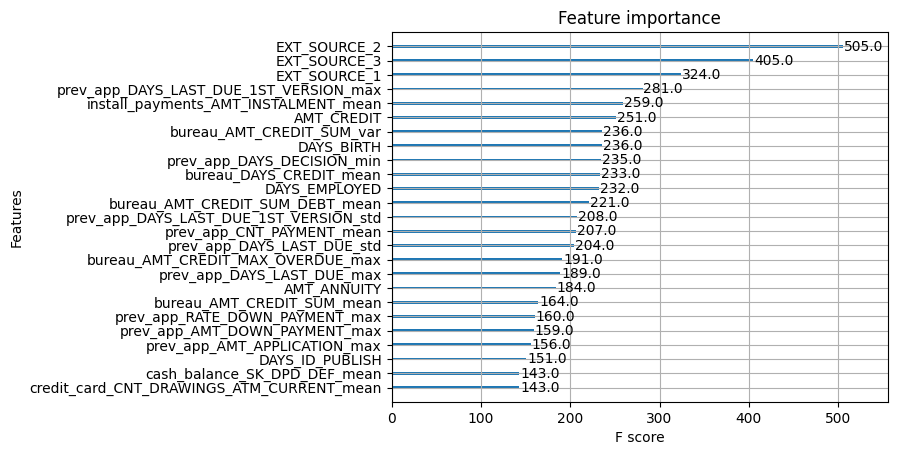

In [25]:
from xgboost import plot_importance
plt.figure(figsize=(50,50))
plot_importance(best_model, max_num_features = 25)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


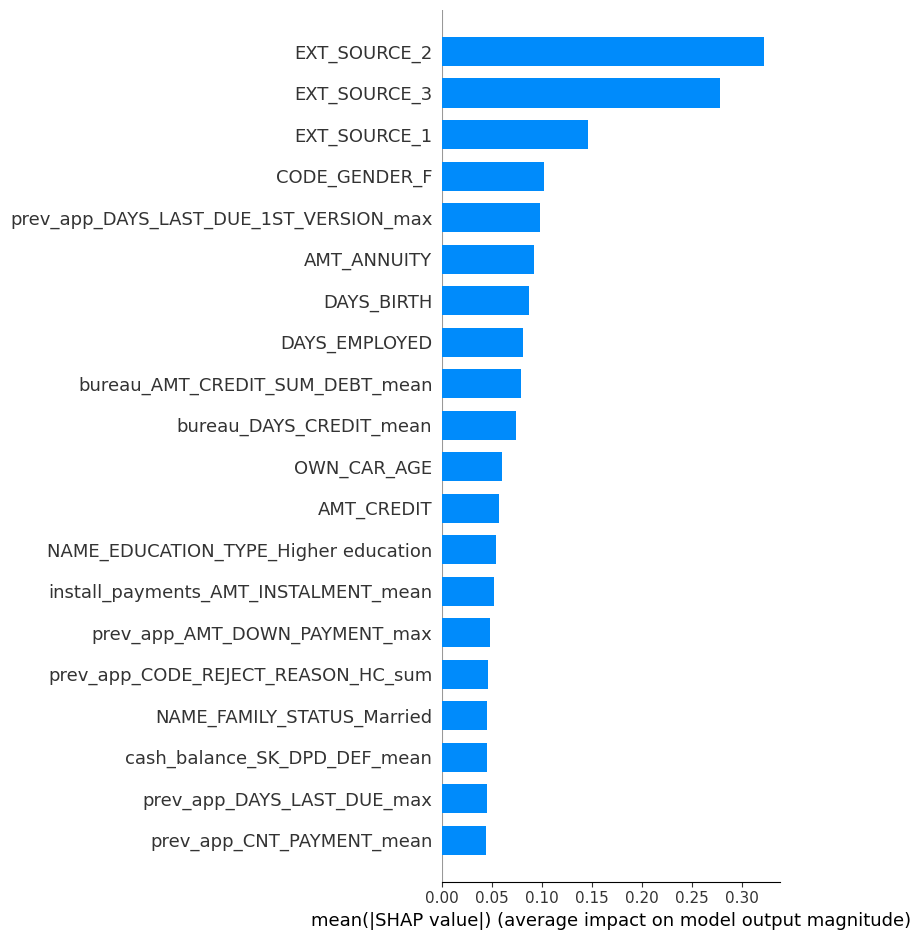

In [26]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, test_x, plot_type="bar")

In [27]:
import pickle

filename = 'XGBoost_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [28]:
show_evaluation(train_x, y_train, best_model, train = True)

-----------------Train Set Evaluation -----------------
Accuracy Score:  0.9231 

Area under ROC Curve:  0.8389 

Average Precision Score:  0.4011 

Confusion Matrix:
                Positive Prediction  Negative Prediction
Positive Class               197672                  219
Negative Class                16344                 1018


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    197891
           1       0.82      0.06      0.11     17362

    accuracy                           0.92    215253
   macro avg       0.87      0.53      0.53    215253
weighted avg       0.92      0.92      0.89    215253



In [29]:
show_evaluation(test_x, y_test, best_model)

-----------------Test Set Evaluation -----------------
Accuracy Score:  0.9197 

Area under ROC Curve:  0.7738 

Average Precision Score:  0.2654 

Confusion Matrix:
                Positive Prediction  Negative Prediction
Positive Class                84604                  185
Negative Class                 7226                  237


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84789
           1       0.56      0.03      0.06      7463

    accuracy                           0.92     92252
   macro avg       0.74      0.51      0.51     92252
weighted avg       0.89      0.92      0.89     92252



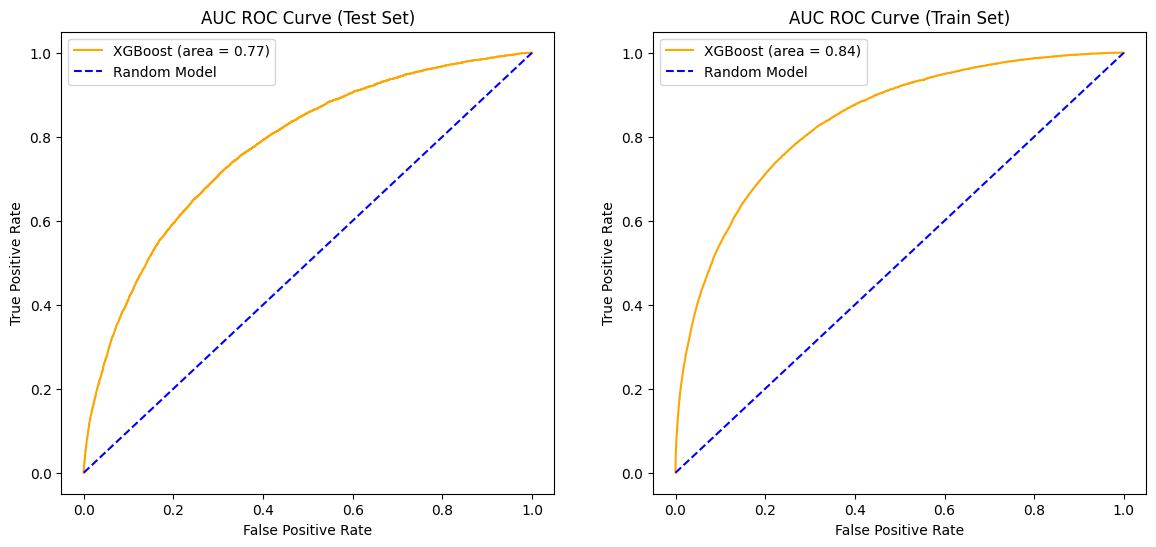

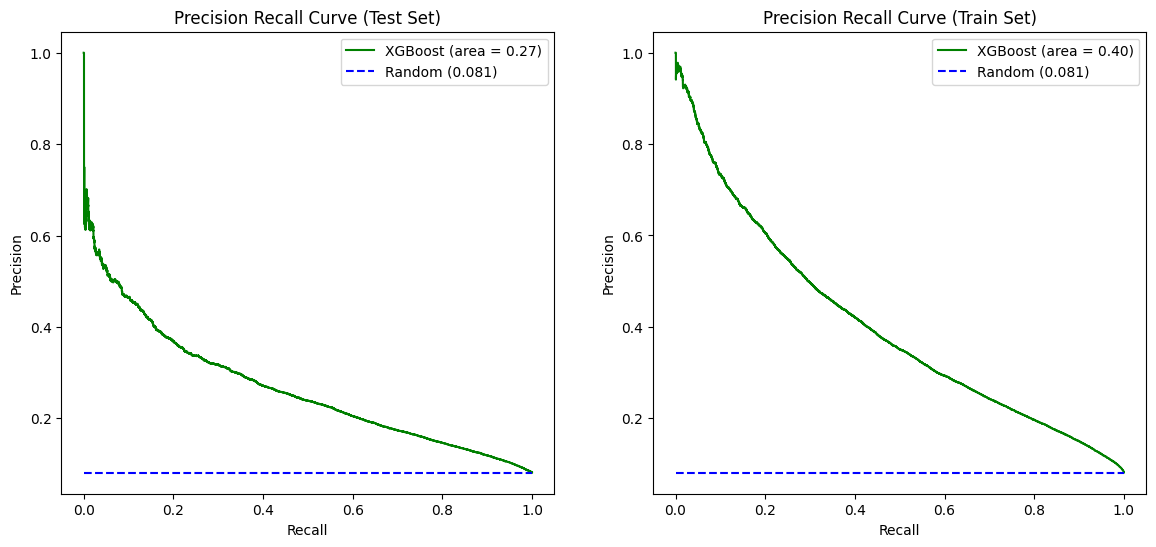

<Figure size 1400x600 with 0 Axes>

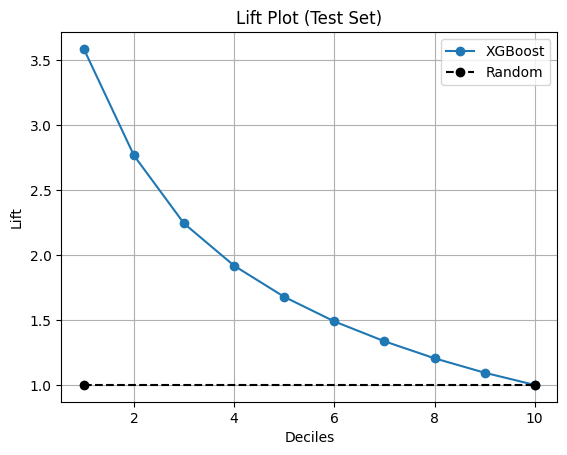

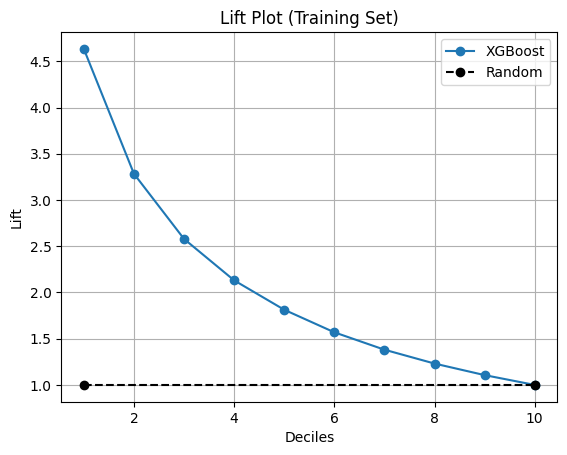

<Figure size 1400x600 with 0 Axes>

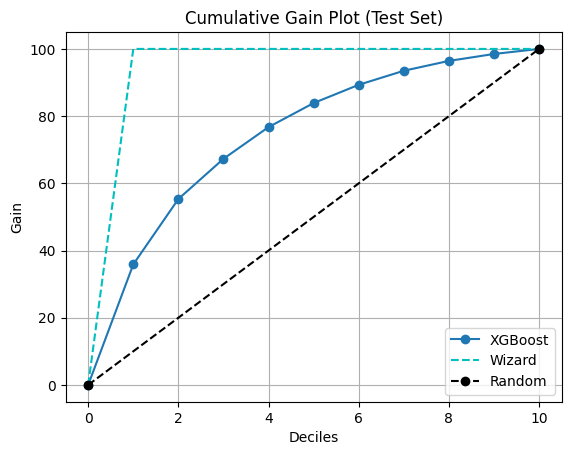

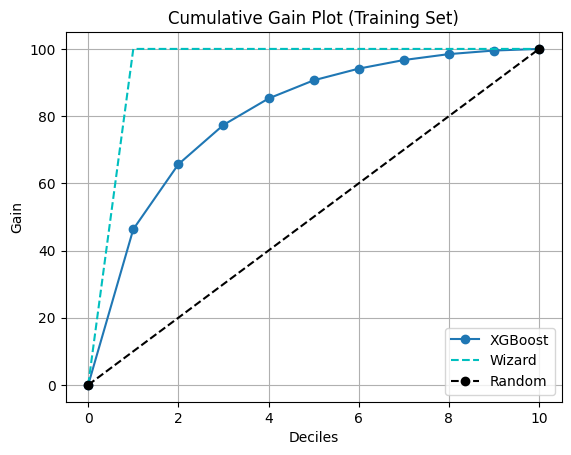

In [30]:
show_plot_metrics(train_x, test_x, y_train, y_test, best_model)